# Imports

In [1]:
import os
import re
import pandas as pd
import numpy as np
from natsort import natsorted
from scipy.integrate import simpson
from scipy.special import gamma
from scipy.optimize import root_scalar

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from py_wake.site._site import UniformSite
from py_wake.site.shear import PowerShear
from py_wake.flow_map import Points

from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

from py_wake.wind_farm_models import PropagateDownwind
from py_wake.deficit_models import BastankhahGaussianDeficit
from py_wake.superposition_models import LinearSum

# Turbines and site

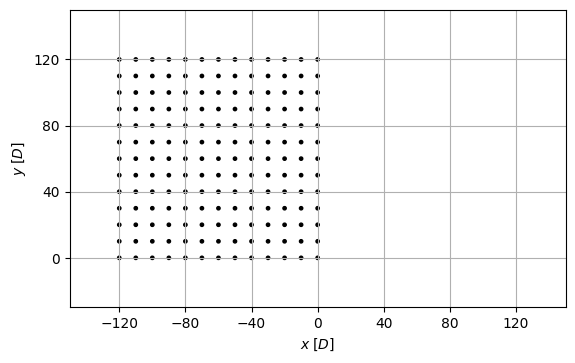

In [2]:
po = [0, 0, 0, 0, 0, 0, 0, 49, 97, 183, 268, 369, 470, 580, 722, 
      900, 1103, 1315, 1526, 1705, 1883, 1940, 1980, 1995, 2000, 
      2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 
      2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000] # https://www.thewindpower.net/turbine_en_779_vestas_v100-2000.php
ct = 0.8 * np.ones_like(po)
u = np.linspace(0, len(po), len(po))

turbine = WindTurbine(name = 'Turbines',
                      diameter = 100,
                      hub_height = 100,
                      powerCtFunction = PowerCtTabular(u, po, 'kW', ct))

site = UniformSite(shear=PowerShear(h_ref=turbine.hub_height(), alpha=.1))

n_rows = 1 + 12
n_cols = 1 + 12

D = turbine.diameter()
s = 10 * D

x_grid, y_grid = np.meshgrid(np.arange(n_cols) * s,
                             np.arange(n_rows) * s)

x = x_grid.ravel()
y = y_grid.ravel()

theta_deg = 0
theta_rad = -np.radians(theta_deg)

rotation_matrix = np.array([
    [np.cos(theta_rad), -np.sin(theta_rad)],
    [np.sin(theta_rad),  np.cos(theta_rad)]
])

xy_rotated = rotation_matrix @ np.vstack([x, y])
x, y = xy_rotated[0], xy_rotated[1]

x = x - np.max(x) # Set x=0 at downstream edge
y = y - np.min(y) # Set y=0 at bottommost turbine

padding = 30 # Padding for display [D]

fig, ax = plt.subplots()

# Plot each turbine as a circle
for x_t, y_t in zip(x, y):
    circle = Circle((x_t/D, y_t/D), 1, color='black', fill=True)
    ax.add_patch(circle)

# Set padded limits
ax.set_xlim(min(x)/D - padding, max(x)/D + 5*padding)
ax.set_ylim(min(y)/D - padding, max(y)/D + padding)

# Retrieve actual limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

tick_interval = 40  # in units of D

# Generate a wide range of ticks
xticks = np.arange(-1000, 1000, tick_interval)
yticks = np.arange(-1000, 1000, tick_interval)

# Clip to axes limits
xticks = xticks[(xticks >= xlim[0]) & (xticks <= xlim[1])]
yticks = yticks[(yticks >= ylim[0]) & (yticks <= ylim[1])]

# Apply ticks
ax.set_xticks(xticks)
ax.set_yticks(yticks)

ax.set_xlabel(r"$x\;[D]$")
ax.set_ylabel(r"$y\;[D]$")
ax.set_aspect('equal')
ax.grid(True)
plt.show()

# Flow map

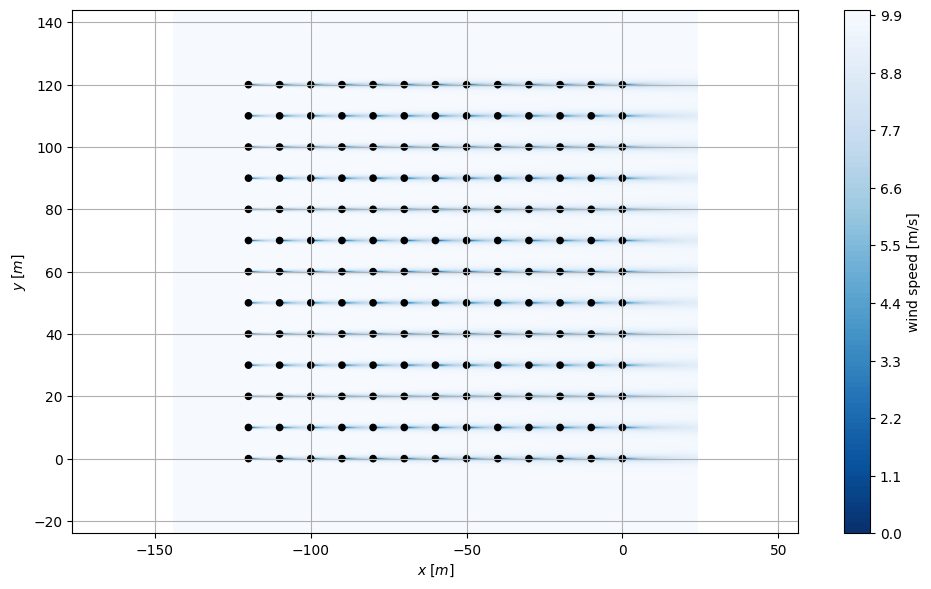

In [3]:
wdir = 270  # [deg]
wsp = 10  # [m/s]
ti = 0.1

mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax = plt.subplots(figsize=(10, 6))

wfm = PropagateDownwind(site, turbine,
                        wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),
                        superpositionModel=LinearSum())
sim = wfm(x, y, ws=wsp, wd=wdir, TI=ti)

sim.flow_map().plot_wake_map(ax=ax, normalize_with=D, plot_windturbines=False)

for x_t, y_t in zip(x, y):
    circle = Circle((x_t/D, y_t/D), radius=1, color='black', fill=True)
    ax.add_patch(circle)
    
ax.set_xlabel(r"$x \; [m]$")
ax.set_ylabel(r"$y \; [m]$")
ax.set_aspect('equal')
ax.grid(True)
plt.tight_layout()
plt.show()

# Load validation data from TDM

In [20]:
validation_data_path = "../ArbitraryLayouts/ValidationData"

# List only files, sorted alphabetically
validation_files = natsorted(
    [f for f in os.listdir(validation_data_path) if os.path.isfile(os.path.join(validation_data_path, f))]
)

validation_datasets = {}
for file in validation_files:
    if file.endswith('.csv'):
        file_path = os.path.join(validation_data_path, file)
        validation_datasets[file] = pd.read_csv(file_path)

print("Loaded datasets:", list(validation_datasets.keys()))

Loaded datasets: ['200D.csv', '600D.csv']


# Wind speed profiles

W: 17737
sigma_tilde: 8868.0
Found n: 39.5600

W: 28659
sigma_tilde: 14330.0
Found n: 15.8743



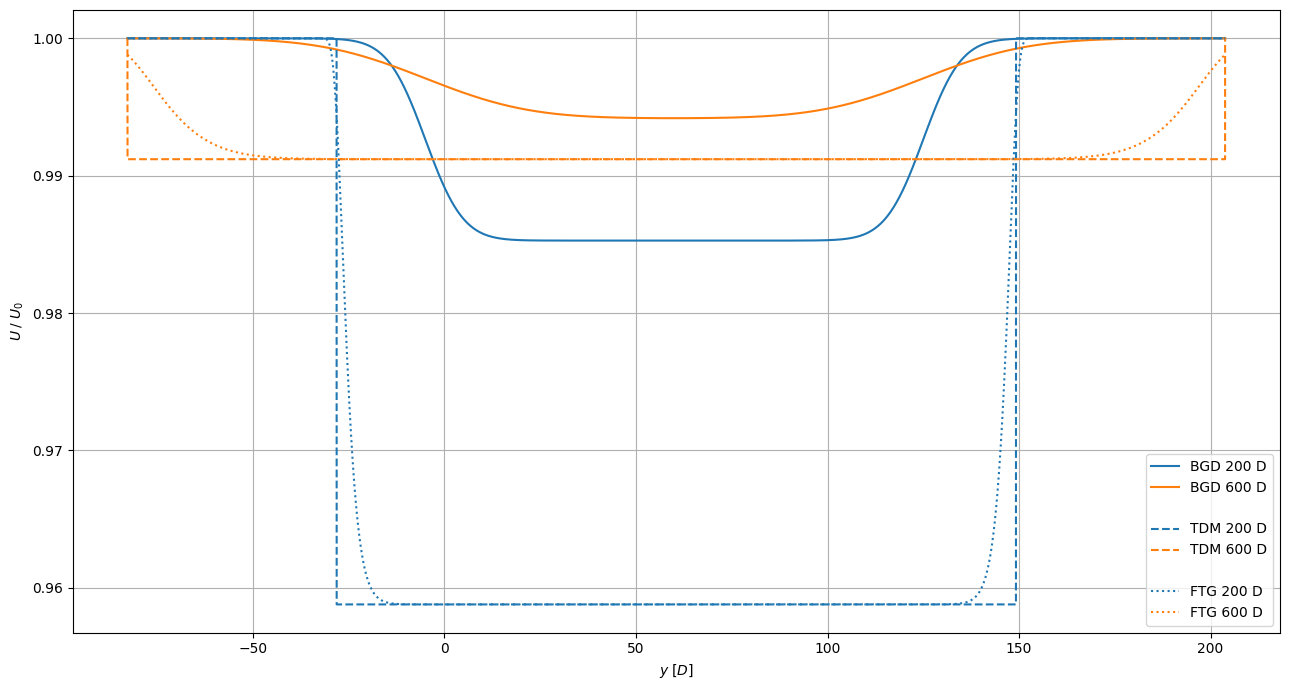

In [21]:
d_downstream = [200, 600]
m_downstream = [d * D for d in d_downstream]

# Use the longest file to define w_meas
longest_file = max(validation_datasets, key=lambda f: len(validation_datasets[f]))
cols = validation_datasets[longest_file].columns
pad_row = pd.DataFrame([np.ones(len(cols))], columns=cols)

validation_datasets[longest_file] = pd.concat([
    pad_row,
    validation_datasets[longest_file],
    pad_row
], ignore_index=True)

w_meas = min(validation_datasets[longest_file].iloc[:, 0].values) * D
y_agreed = max(len(df) for df in validation_datasets.values())
y_range = np.linspace(w_meas, y_agreed + w_meas, y_agreed)
y_meas = np.tile(y_range[:, np.newaxis], (1, len(m_downstream)))
ws_meas = np.zeros_like(y_meas)

padded_tdm = {}
tdm_lengths = {}
ftg_profiles = {}
ftg_n_solutions = {}

fig, ax = plt.subplots(figsize=(13, 7))
ax.set_xlabel(r'$y \; [D]$')
ax.set_ylabel(r'$ U \; / \; U_0 $')
ax.grid(True)

# --- PyWake profiles ---
for i, m in enumerate(m_downstream):
    x_meas = np.full(y_meas.shape[0], max(x) + m)
    ws_meas[:, i] = np.squeeze(
        sim.flow_map(Points(
            x=x_meas,
            y=y_meas[:, i],
            h=turbine.hub_height() * np.ones_like(y_meas[:, i])
        )).WS_eff.values
    )
    ax.plot(y_meas[:, i] / D, ws_meas[:, i] / wsp, label=f'BGD {d_downstream[i]} D')

ax.plot([], [], linestyle='None', marker='', label=' ')

# --- TDM profiles ---
for i, file in enumerate(validation_files):
    match = re.search(r'(\d+)', file)
    downstream_distance = int(match.group(1)) if match else None

    tdm_data = validation_datasets[file]
    tdm_values = tdm_data.iloc[:, 1].values

    if downstream_distance is not None:
        tdm_lengths[downstream_distance] = len(tdm_values)

    # Symmetric padding
    if len(tdm_values) < y_agreed:
        pad_total = y_agreed - len(tdm_values)
        pad_left = pad_total // 2
        pad_right = pad_total - pad_left
        tdm_values = np.pad(tdm_values, (pad_left, pad_right), constant_values=wsp / 10)

    if downstream_distance is not None:
        padded_tdm[downstream_distance] = tdm_values

    if downstream_distance in d_downstream:
        idx = d_downstream.index(downstream_distance)
    else:
        idx = i if i < len(d_downstream) else 0

    color = ax.get_lines()[idx].get_color()
    ax.plot(y_range / D, tdm_values, linestyle='--', color=color, label=f'TDM {downstream_distance} D')

ax.plot([], [], linestyle='None', marker='', label=' ')

# --- Flat-top Gaussian profiles (stored here) ---
for downstream_distance in padded_tdm:
    tdm_values = padded_tdm[downstream_distance]
    tdm_data = validation_datasets[f"{downstream_distance}D.csv"]

    y_col = tdm_data.iloc[:, 0]
    mid = len(y_col) // 2
    y_center = (y_col.iloc[mid - 1] + y_col.iloc[mid]) / 2 if len(y_col) % 2 == 0 else y_col.iloc[mid]
    y_center *= D
    y_range_centered = y_range - y_center

    Cx = 1 - np.min(tdm_values)
    C_T = 0.8
    W = tdm_lengths[downstream_distance]
    sigma_tilde = W / 2
    print('W:', W)
    print('sigma_tilde:', round(sigma_tilde, 0))

    def flat_top_eq(n):
        term1 = 2**(2/n - 1)
        gamma_term = gamma(2/n)
        denom = 16 * gamma_term * sigma_tilde**(4/n)
        term2_inner = 2**(4/n - 2) - (n * C_T) / denom
        if term2_inner < 0:
            return np.inf
        term2 = np.sqrt(term2_inner)
        return term1 - term2 - Cx

    sol = root_scalar(flat_top_eq, bracket=[2, 64], method='brentq')
    if sol.converged:
        n_solution = sol.root
        print(f"Found n: {n_solution:.4f}\n")
    else:
        print("Root finding for n did not converge.\n")
        continue

    U_ftg = Cx * np.exp(-2 * (np.abs(y_range_centered) / sigma_tilde)**n_solution)
    U_ftg = np.clip(U_ftg, 0, None)
    U_ftg = 1 - U_ftg  # Convert to velocity profile

    ftg_profiles[downstream_distance] = U_ftg
    ftg_n_solutions[downstream_distance] = n_solution

    idx = d_downstream.index(downstream_distance) if downstream_distance in d_downstream else 0
    color = ax.get_lines()[idx].get_color()
    ax.plot(y_range / D, U_ftg, linestyle=':', color=color, label=f'FTG {downstream_distance} D')

# --- Finalize plot ---
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()


# Momentum sammenligning

In [6]:
print("\n=== Momentum Comparison ===")
rho = 1.225  # Air density (kg/m^3), optional if only relative comparison

for i, d in enumerate(d_downstream):
    # Get profiles
    U_bgd = ws_meas[:, i]
    U_tdm = padded_tdm[d]
    U_ftg = ftg_profiles[d]

    # Compute momentum per unit depth ( ∫ρU² dy ), but rho cancels in % comparison
    dy = np.mean(np.diff(y_range))

    M_bgd = np.sum(U_bgd**2) * dy
    M_tdm = np.sum(U_tdm*wsp**2) * dy
    M_ftg = np.sum(U_ftg*wsp**2) * dy

    dev_tdm = 100 * (M_tdm - M_bgd) / M_bgd
    dev_ftg = 100 * (M_ftg - M_bgd) / M_bgd

    print(f"{d} D:")
    print(f"  BGD momentum = {M_bgd:.4f}")
    print(f"  TDM momentum = {M_tdm:.4f}  ({dev_tdm:+.2f}% deviation)")
    print(f"  FTG momentum = {M_ftg:.4f}  ({dev_ftg:+.2f}% deviation)\n")



=== Momentum Comparison ===
200 D:
  BGD momentum = 2827975.1605
  TDM momentum = 2792899.9393  (-1.24% deviation)
  FTG momentum = 2795175.7700  (-1.16% deviation)

600 D:
  BGD momentum = 2850873.7613
  TDM momentum = 2840777.6592  (-0.35% deviation)
  FTG momentum = 2842721.8053  (-0.29% deviation)



# Total wsp deficit integration (gammel)

In [7]:
rho = 1.225
integrated_m_pywake = {}
integrated_m_tdm = {}

np.trapezoid(ws_meas[:, 0], )

print('------------- INDIVIDUAL MOMENTUM -------------\n')

# PyWake and TDM integration
for i, d in enumerate(d_downstream):
    if d not in padded_tdm or d not in tdm_lengths:
        print(f"[WARNING] Missing data for {d} D")
        continue

    # Get the y-positions from the TDM file
    y_tdm = validation_datasets[validation_files[i]].iloc[:, 0].values * D
    tdm_profile = validation_datasets[validation_files[i]].iloc[:, 1].values * wsp

    # Determine the mask over y_range that falls within TDM bounds
    mask = (y_range >= y_tdm.min()) & (y_range <= y_tdm.max())

    pywake_profile = ws_meas[mask, i]

    tdm_integral = np.trapezoid(tdm_profile, y_tdm)
    pyw_integral = np.trapezoid(pywake_profile, y_range[mask])

    integrated_m_tdm[d] = rho * tdm_integral**2
    integrated_m_pywake[d] = rho * pyw_integral**2

    print(f"TDM integrated momentum at {d} D: {integrated_m_tdm[d]:.0f} kg*m/s")
    print(f"PyW integrated momentum at {d} D: {integrated_m_pywake[d]:.0f} kg*m/s")

print('\n------------- TOTAL MOMENTUM DEVIATION [%] -------------\n')

for d in d_downstream:
    if d in integrated_m_tdm and d in integrated_m_pywake:
        pyw = integrated_m_pywake[d]
        tdm = integrated_m_tdm[d]
        percent_diff = 100 * (pyw - tdm) / pyw
        print(f"TDM error at {d} D: {percent_diff:.2f}%")

print('\n------------- MOMENTUM DEFICIT DEVIATION [%] -------------\n')

for i, d in enumerate(d_downstream):
    if d not in padded_tdm or d not in tdm_lengths:
        print(f"[WARNING] Missing data for {d} D")
        continue

    y_tdm = validation_datasets[validation_files[i]].iloc[:, 0].values * D
    tdm_profile = validation_datasets[validation_files[i]].iloc[:, 1].values * wsp

    mask = (y_range >= y_tdm.min()) & (y_range <= y_tdm.max())

    pywake_profile = ws_meas[mask, i]
    y_sub = y_range[mask]

    tdm_integral = np.trapezoid(wsp - tdm_profile, y_tdm)
    pyw_integral = np.trapezoid(wsp - pywake_profile, y_sub)

    integrated_m_tdm[d] = rho * tdm_integral**2
    integrated_m_pywake[d] = rho * pyw_integral**2


for d in d_downstream:
    if d in integrated_m_tdm and d in integrated_m_pywake:
        pyw = integrated_m_pywake[d]
        tdm = integrated_m_tdm[d]
        percent_diff = 100 * (pyw - tdm) / pyw
        print(f"TDM error at {d} D: {percent_diff:.2f}%")

print('\n------------- MAXIMUM VELOCITY DEVIATION [%] -------------\n')



print('\n------------- WAKE WIDTH DEVIATION [%] -------------\n')



------------- INDIVIDUAL MOMENTUM -------------

TDM integrated momentum at 200 D: 35423603352 kg*m/s
PyW integrated momentum at 200 D: 37705426265 kg*m/s
TDM integrated momentum at 600 D: 1947988 kg*m/s
PyW integrated momentum at 600 D: 100061331612 kg*m/s

------------- TOTAL MOMENTUM DEVIATION [%] -------------

TDM error at 200 D: 6.05%
TDM error at 600 D: 100.00%

------------- MOMENTUM DEFICIT DEVIATION [%] -------------

TDM error at 200 D: -1358.29%
TDM error at 600 D: -176.69%

------------- MAXIMUM VELOCITY DEVIATION [%] -------------


------------- WAKE WIDTH DEVIATION [%] -------------



# Measurement lines

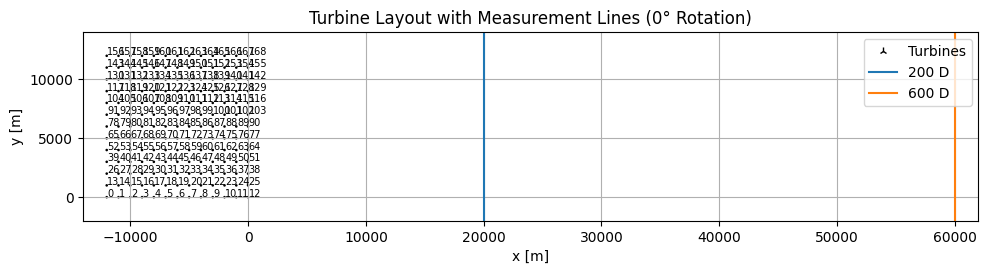

In [8]:
padding = 2000

fig, ax = plt.subplots(figsize=(10, 6))
turbine.plot(x, y, ax=ax)

ax.set_xlim(min(x) - padding, max(x) + max(m_downstream) + padding)
ax.set_ylim(min(y) - padding, max(y) + padding)

# Draw vertical lines at each x_meas (same for all points in a column)
color_map = plt.get_cmap('tab10')
for i, m in enumerate(m_downstream):
    x_line = max(x) + m
    color = color_map(i % 10)
    ax.axvline(x=x_line, color=color, label=f'{d_downstream[i]} D')  # Add label for legend

ax.set_title(f"Turbine Layout with Measurement Lines ({theta_deg}° Rotation)")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_aspect('equal')
ax.grid(True)

# Only show one legend entry per PL
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))  # Remove duplicate labels
ax.legend(unique.values(), unique.keys())

plt.tight_layout()
plt.show()

# Wake min y-coord.

In [9]:
threshold = 0.99999 * wsp

for i, d in enumerate(d_downstream):
    wake_indices = np.where(ws_meas[:, i] < threshold)[0]
    if len(wake_indices) > 0:
        lowest_y = y_range[wake_indices[0]]
        print(f"Lowest y-value of the wake at {d} D: {lowest_y/D:.0f} D")
    else:
        print(f"No wake detected at {d} D")

Lowest y-value of the wake at 200 D: -33 D
Lowest y-value of the wake at 600 D: -69 D
